# ISLR - Chapter 10 - Deep Learning - Exercises

Saad M. Siddiqui - 2022-04-17

# Libraries

In [548]:
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
import os 
import tqdm

from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score, r2_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split


from tensorflow import keras
from tensorflow.keras.datasets import imdb

# Conceptual

## Exercise 01 - Neural Networks as Hypothesis Functions

**Consider a neural network with two hidden layers: $p = 4$ input units, 2 units in the first hidden layer, 3 units in the second hidden layer, and a single output.**

### Part (a)
**Draw a picture of the neural network.**

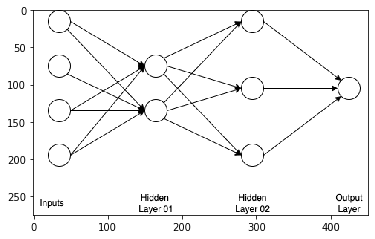

In [551]:
nn_image = plt.imread("./chapter_10_ex_01.png", )
plt.imshow(nn_image)

I used [diagrams.net](diagrams.net) to make this neural network picture.

This diagram does not show the single **bias** unit, which is assumed to implicitly always be a part of each layer, including the input but not the output.

## Part (b)
**Write out an expression for $f(X)$ assuming ReLU activation functions. Be as explicit as you can.**

Assume the inputs are $X_j \ \forall j \in \{1, 2, 3, 4\}$.

Assume that the 2 hidden units in Layer 01 are to be indexed by $k \in [1, 2]$.

Assume that the edges of the graph connecting input $X_j$ to the hidden layer unit $k$ is $W_{kj}$.

This makes the activation of the $k^{th}$ unit in hidden layer 1 $A_k^{(1)}$ as follows 
$$
\begin{align}
A_k^{(1)} &= h_k^{(1)}\left(X\right) \\
A_k^{(1)} &= g\left(W_{k0}^{(1)} + \sum\limits_{j = 1}^{p}W_{kj}^{(1)}X_j\right) \ \forall \ k \in \{1, 2\}\\
\text{where} \  g(z) &= ReLU(z)
\end{align} 
$$

We extend this analysis to subsequent layers.

Assume the activations for the 1st hidden layer are $A_k^{(1)} \ \forall \ \ k \in \{1, 2 \}$.

Assume the three hidden units in hidden layer 02 are indexed by $l \ \in \{1, 2, 3 \}$.

Assume the weight assigned to the edge of the graph connecting unit $k$ from the first hidden layer to the unit $l$ in the second hidden layer is $W_{lk}^{(2)}$.

This makes the activation of the $l^{(th)}$ unit in hidden layer 2 $A_l^{(2)}$ as follows

$$
\begin{align}
A_l^{(2)} &= h_l^{(2)}(A_k^{\left(1\right)}) \\
A_l^{(2)} &= g\left(W_{l0}^{(1)} + \sum\limits_{k = 1}^{K = 2}W_{lk}^{(2)}A_{k}^{(1)}\right) \ \forall \ l \ \in \{1, 2, 3\} \\
\text{where, again} \ g(z) &= ReLU(z)
\end{align}
$$

Applying this analysis to the final layer.

The output $f$ for the neural network is the activation of the single activation unit in output layer. This depends on the activations from the previous layer $A_{l}^{(2)} \ \forall \ l \in \ \{1, 2, 3\}$.

Assume the weights assigned to the connections from node $l$ in hidden layer 02 to the output unit are given by $W_{1l}^{(3)}$.

Concretely,

$$
\begin{align}
f &= g\left(W_{10}^{(3)} + \sum\limits_{l = 1}^{L = 3}W_{1l}^{(3)}A_{l}^{(2)}\right) \\
\text{where} \ g &= ReLU
\end{align}
$$

Plugging in these equations can back into each other can result in a very, very messy equation. 

But generally, we can write the final output as a series of abstracted, chained ReLU operations. 
$$
f(X) = g_3\left(g_2\left(g_1(X)\right)\right)
$$

### Part (c)

**Now plug in some vlaues for the coefficients and write out the value of $f(X)$.**

Too messy to attempt with `ReLU`. 

### Part (d)

**How many parameters are there?**

Generally, assuming the bias input is not dropped, the number of parameters for fully connected layer between the 'first' layer $L$ with $l$ units and 'subsequent' layer $M$ with $m$ units is $m \times (L + 1)$.

In case of input layer and first hidden layer, $L = 4$ and $M = 2$ so $2 \times (4 + 1) = 10$ parameters.

In case of first hidden layer and second hidden layer, $L = 2$ and $M = 3$ so $3 \times (2 + 1) = 9$ parameters.

In case of second hidden layer and output layer, $L = 3$ and $M = 1$ so $1 \times (3 + 1) = 4$ parameters.

This brings the total to $10 + 9 + 4 = 23$ parameters.

We can verify this by actually constructing the network and using the `summary` function.

In [4]:
my_test_network = keras.models.Sequential([
    keras.layers.Input(shape = (4,)), 
    keras.layers.Dense(units = 2, activation = 'relu'), 
    keras.layers.Dense(units = 3, activation = 'relu'), 
    keras.layers.Dense(units = 1, activation = 'relu')
])

my_test_network.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 2)                 10        
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 9         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 4         
Total params: 23
Trainable params: 23
Non-trainable params: 0
_________________________________________________________________


This is the same number we derived above.

## Exercise 02 - Softmax Activation 
**Consider the *softmax* function in (10.13) for modeling multinomial probabilities.**

### Part (a) 
**In (10.13), show that if we add a constant $c$ to each of the $z_l$ then the probability is unchanged.**

The softmax probability in (10.13) is defined as 
$$
f_m(X) = Pr(Y = m | X) = \frac{e^{Z_m}}{\sum\limits_{l = 0}^{9}e^{Z_l}}
$$

I am assuming that by "adding a constant" to the $Z_l$ the authors mean $Z_l + c$. 

Since $m$ is just a specific value of $l$, this means the $c$ is also added to the $Z_m$ term in the numerator.

$$
\begin{align}
f_m(X) &= \frac{e^{(Z_m + c)}}{\sum_{l = 0}^{9}e^{(Z_l + c)}} \\
\\since \ e^{(a + b)} &= e^ae^b \\
f_m(X) &= \frac{e^{Z_m}e^c}{\sum_{l = 0}^9e^{Z_l}e^c} \\
f_m(X) &= \frac{e^ce^{Z_m}}{e^c\left(\sum_{l = 0}^{L 9}e^{Z_l}\right)} \\ 
f_m(X) &= \frac{e^{Z_m}}{\sum_{l = 0}^{L 9}e^{Z_l}}
\end{align}
$$

which is the same as the original expression.

### Part (b) 
**In (4.13), show that if we add constants $c_j = 0, 1, ..., p$ to each fo the corresponding coefficients for each of the classes, then the predictions at any new point $x$ are unchanged.**

The equation (4.13) is as follows
$$
Pr(Y = k | X = x ) = \frac{e^{\beta_{k0} + \beta_{k1} x_1 + \beta_{k2} x_2 + ... \beta_{kp} x_p}}{\sum\limits_{l = 1}^Ke^{{\beta_{l0} + \beta_{l1} x_1 + \beta_{l2} x_2 + ... \beta_{lp} x_p}}}
$$

The question is adding a constant $c_j$ to each of the coeffiicients. This makes the equation
$$
Pr(Y = k | X = x ) = \frac{e^{(\beta_{k0} + c_0) + (\beta_{k1} + c_1) x_1 + (\beta_{k2} + c_2) x_2 + ... (\beta_{kp} + c_p)x_p}}{\sum\limits_{l = 1}^K{e^{(\beta_{l_0} + c_0) + (\beta_{l_1} + c_1) x_1 + (\beta_{l_2} + c_2) x_2 + ... + (\beta_{l_p} + c_p) x_p}}}
$$

But the addition of a constant term to anothe constant term is just another constant term. Specifically, 
$$
\beta_{kj} + c_j = \beta_{kj}'
$$

This essentially transforms the equation to 
$$
Pr(Y = k | X = x ) = \frac{e^{\beta_{k0}' + \beta_{k1}' x_1 + \beta_{k2}' x_2 + ... \beta_{kp}' x_p}}{\sum\limits_{l = 1}^K{e^{\beta_{l0}' + \beta_{l1}' x_1 + \beta_{l2}' x_2 + ... \beta_{lp}' x_p}}}
$$

So the original formulation remains unchanged. 

This shows that the softmax function is *over-parameterized*. However, regularization and SGD typically constrain the solutions so this is not a problem.

## Exercise 03 - Multinomial Log Likelihood

**Show that the negative multinomial log likelihood (10.14) is equivalent to the negative of the likelihood expression (4.5) when there are $M = 2$ classes.**

Tried. Failed. :(

## Exercise 04 - CNN 

**Consider a CNN that takes $32 \times 32$ grayscale images and has a single convolutional layer with three $5 \times 5$ convolutional filters (without boundary padding).**

### Part (a)
**Draw a sketch of the input and first hidden layer similar to Figure 10.8.**

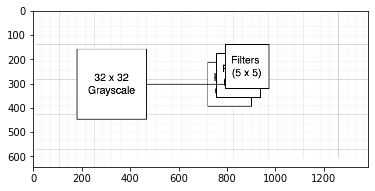

In [556]:
my_nn = plt.imread("./cnn_diagram.png")
plt.imshow(my_nn)

### Part (b) 
**How many parameters are in this model?**

There are three filters. Each filter is of size $(5, 5)$. Each cell in each filter is a parameter. This means there are $5 \times 5 \times 3 = 75$ parameters within the filters alone.

Additionally, there is one bias weight per filter. This means $75 + 3 = 78$ parameters in total.

We can verify this by constructing the network in `keras` and checking its `summary`.

In [3]:
test_cnn = keras.models.Sequential([
    keras.layers.Input(shape = (32, 32, 1,)), 
    keras.layers.Conv2D(filters = 3, kernel_size = (5, 5), activation = 'relu')
])

print(test_cnn.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 3)         78        
Total params: 78
Trainable params: 78
Non-trainable params: 0
_________________________________________________________________
None


### Part (c) 
**Explain how this model can be thought of as an ordinary feed forward neural network with the individual pixels as inputs, and with constraints on the weights in the hidden units. What are the constraints?**

We can think of the CNN as a feed forward neural network where the inputs are $32 \ times 32$ dimensional vectors. The filter weights can be thought of as the parameters going from the features in the input layer to the hidden layer, with one unit for each pixel in the hidden layer. 

Essentially, in the convolutional operation, each element within the $5 \times 5$ feature map becomes the weight mapping an input feature $X_j$ to the same location in the activation map produced by the filter. 

The constraint is that the weights within the filter map must be location invariant: they should be the same for processing pixels $1 - 25$ and the same for processing pixels $2 - 26$. They cannot change with the specific subset of inputs being processed. This reusability ensures weights are constrained.

### Part (d)
**If there were no constraints, then how many weights would there be in the ordinary neural network in (c)?**

Removing the constraint in the feedforward representation of the CNN means removing the requirement for the weights to be location invariant: in other words, the weights of each filter can be different for each pixel of the input image. 

This means the total number of weights are $[(32 + 1) \times 5 \times 5 \times 3] = [33 \times 5 \times 5 \times 3] = 2475$

## Exercise 05 - MAE and $R^2$

**In table 10.2 on page 433, we see that the ordering of the three methods with respect ot mean absolute error is different from the ordering with respect to the test set $R^2$. How can this be?**

![image.png](attachment:image.png)

According to the MAE, the models (in order of better performance) are the lasso, linear regression, and finally the neural network.

However, according to the $R^2$, the models (in order of better performance) are the lasso, neural network, and linear regression. 

This discrepancy is because the two metrics measure different things and only one is dependent on the number of features used. 

MAE is a measure of how different the magnitude of the predictions is compared to the ground truth. 

$R^2$ is not directly concerned with the magnitude of the predictions relative to the target, but rather the proportion of the variance in the target that is explained by the model. 

$R^2$ will always increase with the addition of a new variable, even if that variable does not significantly contribute to reductions in MAE (or even if the variable actually increases the MAE by introducing noise). 

However, MAE will only improve if the addition of a variable actually decreases the average magnitude of errors made on the test set. With too many insignifcant predictors, this can actually increase rather than decrease.

The lasso has the lowest $R^2$ because it performs feature selection and removes a lot of variables from the final fit. With fewer predictors in the final fit, $R^2$ is generally lower. However, removing the variables does mitigate overfitting, which is why it has lower MAE. 

Linear regression has all 20 of the features originally fed into the model, so it has a higher $R^2$ but also higher MAE. 

Highest MAE with neural network is a consequence of the number of parameters being substantially larger, resulting in more overfitting.

# Applied Exercises

## Exercise 06 - Sinusoid Function

Consider the simple function $R(\beta) = sin(\beta) + \frac{\beta}{10}$.

### Part (a)

**Draw a graph of this function over the range $\beta \ \in \ [-6, 6]$.**

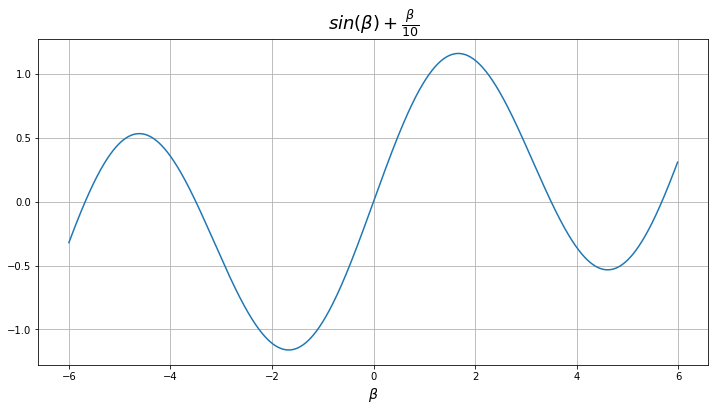

In [17]:
beta = np.arange(start = -6, stop = 6, step = 0.01)
r_beta = np.sin(beta) + beta / 10.0 
plt.figure(figsize = (12, 6));
plt.plot(beta, r_beta)
plt.grid(True);
plt.title(r'$sin(\beta) + \frac{\beta}{10}$', size = 18);
plt.xlabel(r'$\beta$', size = 14); 

### Part (b) 
**What is the derviative of this function?**

$$
\begin{align}
R'(\beta) &= \frac{d}{d\beta}\left(sin(\beta) + \frac{\beta}{10}\right) \\
R'(\beta) &= cos(\beta) + \frac{1}{10}
\end{align}
$$

### Part (c) 
**Given $\beta^0$ = 2.3, run gradient descent to find the local minimum of $R(\beta)$ using a learning rate of $p = 0.1$. Show each of $\beta_0$, $\beta_1, ..., \beta_p$ in your plot, as well as the final answer.**

I define a function called `run_gradient_descent` which will use an arbitrary `fn`, its gradent function `grad_fn`, and an `init_value` to perform gradient descent to the local optimum. 

In [55]:
def run_gradient_descent(
    fn, grad_fn, init_value = 2.3, lr = 0.1,
    max_iter = 5000, eps = 1e-6, log_to_console = False):
    # Make a list to track all betas during gradient descent 
    # along with their corresponding function value
    beta_all = []
    fn_all = [] 
    
    # Flags to control the for gradient descent loop. Stop if 
    # convergence reached (diff b/w subsequent beta = 1e-6)  or 
    # if exceeded maximum iterations
    has_converged = False 
    exceeded_iter = False 
    
    # For first iteration, beta is `init_value` provided
    beta_all.append(init_value)
    fn_all.append(fn(init_value))
    n_iters = 0
    
    # Run gradient descent loop until convergence or exceeding iters
    while (has_converged == False | exceeded_iter == False):
        # Current beta is the last beta logged in the list 
        beta_current = beta_all[-1]
        
        # Compute the gradient at this value 
        grad_beta = grad_fn(beta_current)
        
        # Use the gradient to compute next beta and append to log 
        beta_new = beta_current - lr * grad_beta 
        beta_all.append(beta_new)
        
        # Also append corresponding fn value to log
        fn_all.append(fn(beta_new))
        
        # Increment iterations, and check if exit conditions satisfied
        n_iters += 1
        
        if (n_iters > max_iter): 
            exceeded_iter = True 
        
        if (abs(beta_new - beta_current) < eps):
            has_converged = True
        
        # log for each step if required
        if log_to_console:
            print(f"Iteration: {n_iters} | grad: {np.round(grad_beta, 4)} | beta: {np.round(beta_current, 4)} | beta_new : {np.round(beta_new, 4)} | converged: {has_converged} | exceeded_iter : {exceeded_iter}")
        
    # At end of function return data frame of descent summary and 
    # the final value of beta 
    summary_df = pd.DataFrame({
        'beta': beta_all, 
        'fn': fn_all
    }).reset_index().rename({'index': 'iter'}, axis = 1)
    
    return (summary_df, beta_all[-1])    

In [56]:
# Define the function and its derivative 
def r_beta(beta): 
    return np.sin(beta) + beta / 10.0 

def grad_r_beta(beta):
    return np.cos(beta) + 1.0 / 10.0

summary_df, final_beta = run_gradient_descent(
    fn = r_beta, grad_fn = grad_r_beta, init_value = 2.3, lr = 0.1
)

print(f"Gradient Descent concluded with: {summary_df.shape[0]} iters at beta = {np.round(summary_df['beta'].tolist()[-1], 2)}")

Gradient Descent concluded with: 130 iters at beta = 4.61


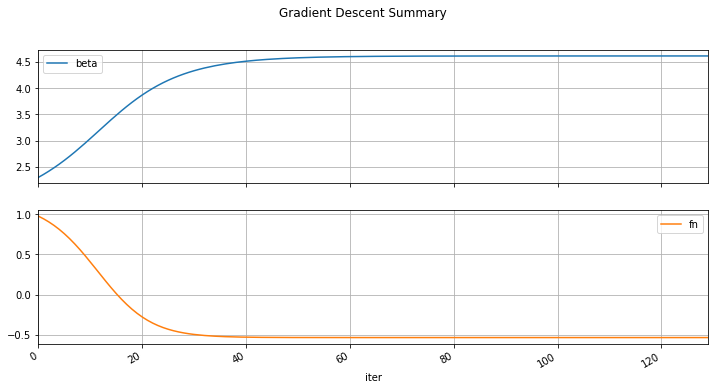

In [57]:
summary_df.plot(
    x = 'iter', subplots = True,
    grid = True, figsize = (12, 6),  legend = True, 
    title = 'Gradient Descent Summary'
);

We can see that gradient descent reaches the local minimum of 4.61 by 130 iterations. This is not the global minimum in the feature space, which shows that gradient descent is susceptible to getting stuck in local minima depending on initialization.

### Part (d)

**Repeat with $\beta^0$ = 1.4**.

Gradient Descent concluded with: 140 iters at beta = -1.67


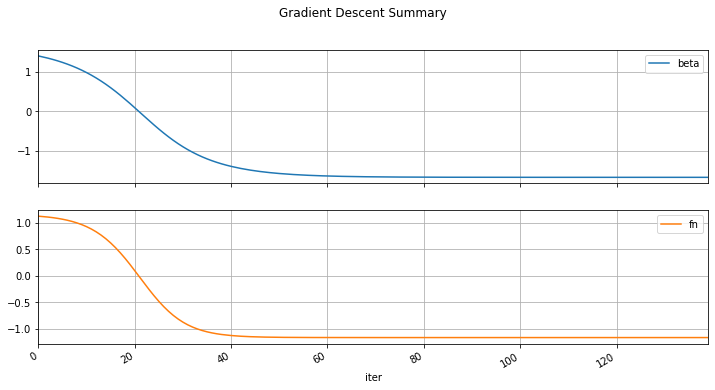

In [58]:
summary_df, final_beta = run_gradient_descent(
    fn = r_beta, grad_fn = grad_r_beta, init_value = 1.4, lr = 0.1
)

print(f"Gradient Descent concluded with: {summary_df.shape[0]} iters at beta = {np.round(summary_df['beta'].tolist()[-1], 2)}")

summary_df.plot(
    x = 'iter', subplots = True,
    grid = True, figsize = (12, 6),  legend = True, 
    title = 'Gradient Descent Summary'
);

Initializing $\beta$ to a different value resulted in a completely different minimum value of the function.

## Exercise 07 - `Default` Data

**Fit a neural network to the `Default` data. Use a single hidden layer with 10 units, and dropout regularization. Compare the classification performance of your model with that of linear logistic regression.**

I first read in the `Default` data set from a CSV I exported from within `R`.

In [115]:
default_data = pd.read_csv("./default_data.csv")
default_data.drop('Unnamed: 0', axis = 1, inplace = True)
default_data.head()

# Extract the target and predictors into different dataframes
default_X = default_data.drop('default', axis = 1) 
default_y = default_data['default']

# Check shapes 
print("X Shape: ", default_X.shape)
print("y Shape: ", default_y.shape)

X Shape:  (10000, 3)
y Shape:  (10000,)


Split the data into a training test set.

In [116]:
np.random.seed(163) 
X_train, X_test, y_train, y_test = train_test_split(
    default_X, default_y, test_size = 0.2
)

print("X_train Shape: ", X_train.shape)
print("X_test Shape: ", X_test.shape)
print("y_train Shape: ", y_train.shape)
print("y_test Shape: ", y_test.shape)

X_train Shape:  (8000, 3)
X_test Shape:  (2000, 3)
y_train Shape:  (8000,)
y_test Shape:  (2000,)


In [117]:
# Make a preprocessing pipeline that one-hot encodes the categorical 
# `student` variable and normalizes the continuous features 
cat_attribs = ['student']
num_attribs = default_X.columns[~default_X.columns.isin(cat_attribs)]

default_col_transformer = ColumnTransformer([
    ('cat_one_hot', 
     OneHotEncoder(handle_unknown = 'ignore'), cat_attribs), 
    ('num_standard_scaler', StandardScaler(), num_attribs)
])

# Learn transformations from training data 
X_train = default_col_transformer.fit_transform(X_train)

# Apply transformations to test data
X_test = default_col_transformer.transform(X_test)

# Check shapes
print("X_train Shape: ", X_train.shape)
print("X_test Shape: ", X_test.shape)
print("y_train Shape: ", y_train.shape)
print("y_test Shape: ", y_test.shape)

X_train Shape:  (8000, 4)
X_test Shape:  (2000, 4)
y_train Shape:  (8000,)
y_test Shape:  (2000,)


In [118]:
pd.DataFrame(X_train).describe()

,0,1,2,3
count,8000.000000,8000.000000,8.000000e+03,8.000000e+03
mean,0.704500,0.295500,-3.413936e-17,1.199388e-16
std,0.456296,0.456296,1.000063e+00,1.000063e+00
min,0.000000,0.000000,-1.719218e+00,-2.455744e+00
25%,0.000000,0.000000,-7.406263e-01,-9.097663e-01
50%,1.000000,0.000000,-2.922894e-02,7.253884e-02
75%,1.000000,1.000000,6.836374e-01,7.668684e-01
max,1.000000,1.000000,3.751462e+00,2.940797e+00


In [119]:
pd.DataFrame(X_test).describe()

,0,1,2,3
count,2000.000000,2000.000000,2000.000000,2000.000000
mean,0.710000,0.290000,0.012637,0.045971
std,0.453876,0.453876,0.984628,1.018721
min,0.000000,0.000000,-1.719218,-2.155896
25%,0.000000,0.000000,-0.688993,-0.892549
50%,1.000000,0.000000,-0.004765,0.160801
75%,1.000000,1.000000,0.692530,0.835594
max,1.000000,1.000000,3.202917,3.023069


We now fit a simple logistic regression model to the data. We use cross-validation to find the optimal value for the ridge regression penalty coeffcient.

In [120]:
default_logreg_fit = LogisticRegressionCV(Cs = 10, cv = 5, penalty = 'l2', scoring = 'accuracy', verbose = 1).fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.4s finished


In [121]:
default_logreg_fit.C_

array([2.7825594])

In [153]:
default_logreg_pred = default_logreg_fit.predict(X_test)
defualt_logreg_acc = accuracy_score(y_true = y_test, y_pred = default_logreg_pred)
print(f"Test Set accuracy with Logistic Regression: {np.round(defualt_logreg_acc, 4)}")

Test Set accuracy with Logistic Regression: 0.9705


With logistic regression, we get 97% accuracy on this data set!

We now fit a simple feed-forward neural network with some dropout regularization to the same data.

The only change for the data is to convert the targets from strings like `Yes` and `No` to numeric data which can be fed to `keras`.

In [123]:
# Instantiate
label_encoder_ann = LabelEncoder()

# Learn mapping from training data and transform it 
y_train_ann = label_encoder_ann.fit_transform(y_train)

# Transform test data using mappings learnt from test data
y_test_ann = label_encoder_ann.transform(y_test)

# Shapes shouldn't change
print("y_train shape: ", y_train_ann.shape)
print("y_test shape: ", y_test_ann.shape)

# But values will have changed
print("y_train value counts") 
print(y_train.value_counts())

print("\ny_test value counts")
print(y_test.value_counts())

y_train shape:  (8000,)
y_test shape:  (2000,)
y_train value counts
No     7734
Yes     266
Name: default, dtype: int64

y_test value counts
No     1933
Yes      67
Name: default, dtype: int64


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 10)                50        
_________________________________________________________________
dropout_1 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 61
Trainable params: 61
Non-trainable params: 0
_________________________________________________________________
None


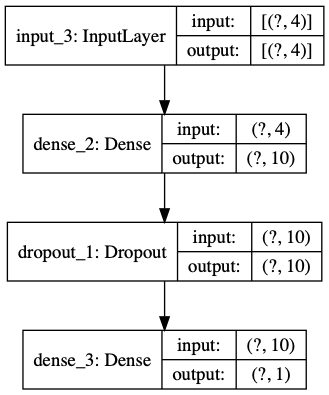

In [124]:
# Training proceeds as before
default_ann = keras.models.Sequential([
    keras.layers.Input(shape = (X_train.shape[-1])),
    keras.layers.Dense(units = 10, activation = 'relu'),
    keras.layers.Dropout(rate = 0.3), 
    keras.layers.Dense(units = 1, activation = 'sigmoid')
])

print(default_ann.summary())

keras.utils.plot_model(default_ann, show_shapes = True, show_layer_names = True)

In [125]:
default_ann.compile(loss = 'binary_crossentropy', 
                    optimizer = 'rmsprop', 
                    metrics = ['accuracy'])

default_ann_history = default_ann.fit(
    x = X_train, y = y_train_ann, batch_size = 32, epochs = 25, 
    validation_split = 0.8
)

Train on 1599 samples, validate on 6401 samples
Epoch 1/25
1599/1599 [==============================] - 1s 483us/sample - loss: 0.7304 - accuracy: 0.5153 - val_loss: 0.6451 - val_accuracy: 0.5185
Epoch 2/25
1599/1599 [==============================] - 0s 215us/sample - loss: 0.6315 - accuracy: 0.6929 - val_loss: 0.5425 - val_accuracy: 0.9680
Epoch 3/25
1599/1599 [==============================] - 0s 202us/sample - loss: 0.5274 - accuracy: 0.8555 - val_loss: 0.4522 - val_accuracy: 0.9680
Epoch 4/25
1599/1599 [==============================] - 0s 200us/sample - loss: 0.4495 - accuracy: 0.9124 - val_loss: 0.3755 - val_accuracy: 0.9680
Epoch 5/25
1599/1599 [==============================] - 0s 190us/sample - loss: 0.3872 - accuracy: 0.9581 - val_loss: 0.3124 - val_accuracy: 0.9680
Epoch 6/25
1599/1599 [==============================] - 0s 195us/sample - loss: 0.3249 - accuracy: 0.9612 - val_loss: 0.2600 - val_accuracy: 0.9680
Epoch 7/25
1599/1599 [==============================] - 0s 192us

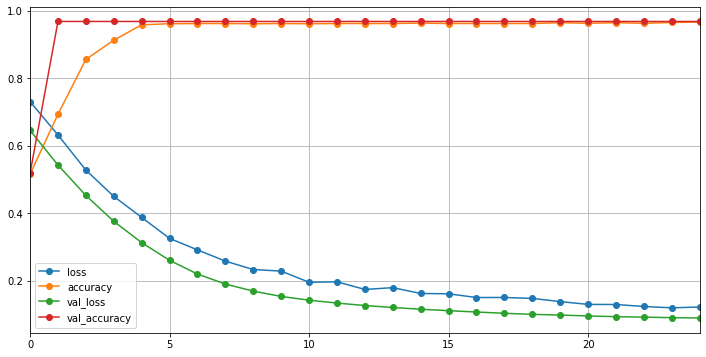

In [128]:
pd.DataFrame(default_ann_history.history).plot(
    figsize = (12, 6), 
    grid = True, 
    marker = 'o'
)

The validation set accuracy doesn't look like it ever increases past 96.8%. Train accuracy actually seems to "catch up" later.

In [155]:
default_ann_pred = default_ann.predict_classes(X_test)
default_ann_acc = accuracy_score(y_true = y_test_ann, y_pred = default_ann_pred)
print(f"Test Set accuracy with ANN: {np.round(default_ann_acc, 4)}")

Test Set accuracy with ANN: 0.9665


The accuracy of the ANN is 96.65% which is slightly lower than the 97.05% accuracy of the logistic regression model. 

What's interesting is that the logistic regression model does make predictions for the positive class. However, all predictions from the ANN are for the majority class. It's as if the network has learned it can minimize binary crossentropy by simply predicting the majority class, regardless of the features.

In [157]:
pd.Series(default_ann_pred.ravel()).value_counts()

0    2000
dtype: int64

In [158]:
pd.Series(default_logreg_pred).value_counts()

No     1972
Yes      28
dtype: int64

Thus, the logistic regression model is probably better because it seems to have actually learnt a mapping for the minority class. While the neural network has comparable accuracy, there isn't much learning going on here.

## Exercise 09 - Autoregressive Model with `month`
**Fit a 5-lag autoregressive model to the `NYSE` data as described in the text and Lab 10.9.6. Refit the model with a 12-level factor representing the month. Does the factor improve the performance of the model?**

For simplicity, I will simply fit the model with the new model with the `month` factor. I won't refit the original model, and will just use the results from the lab.

In [196]:
# Data loading proceeds as before
nyse_data_raw = pd.read_csv("./nyse_data.csv").drop('Unnamed: 0', axis = 1)
nyse_data_raw['date'] = pd.to_datetime(nyse_data_raw['date'])

# Create a month column
nyse_data_raw['month'] = nyse_data_raw['date'].apply(lambda x: x.month)


nyse_data_raw.set_index('date', inplace = True)
nyse_data_raw.head()

,day_of_week,DJ_return,log_volume,log_volatility,train,month
date,,,,,,
1962-12-03,mon,-0.004461,0.032573,-13.127403,True,12
1962-12-04,tues,0.007813,0.346202,-11.749305,True,12
1962-12-05,wed,0.003845,0.525306,-11.665609,True,12
1962-12-06,thur,-0.003462,0.210182,-11.626772,True,12
1962-12-07,fri,0.000568,0.044187,-11.728130,True,12


Categorical data processing has an extra step for one-hot encoding month as well.

In [197]:
nyse_cat_data_dow = pd.get_dummies(nyse_data_raw['day_of_week'])
nyse_cat_data_month = pd.get_dummies(nyse_data_raw['month'])
nyse_cat_data_month.columns = ['month_' + str(x) for x in nyse_cat_data_month.columns]

nyse_cat_data = pd.merge(nyse_cat_data_dow, nyse_cat_data_month, 
                        left_index = True, right_index = True)

In [198]:
nyse_cat_data.isna().mean(axis = 0)

fri         0.0
mon         0.0
thur        0.0
tues        0.0
wed         0.0
month_1     0.0
month_2     0.0
month_3     0.0
month_4     0.0
month_5     0.0
month_6     0.0
month_7     0.0
month_8     0.0
month_9     0.0
month_10    0.0
month_11    0.0
month_12    0.0
dtype: float64

The rest of the data preprocessing proceeds as before.

In [199]:
nyse_train_data = nyse_data_raw[nyse_data_raw['train'] == True].drop(['day_of_week', 'month', 'train'], axis = 1)
nyse_test_data = nyse_data_raw[nyse_data_raw['train'] == False].drop(['day_of_week', 'month', 'train'], axis = 1)

In [200]:
print("Train Shape: ", nyse_train_data.shape)
nyse_train_data.head()

Train Shape:  (4281, 3)


,DJ_return,log_volume,log_volatility
date,,,
1962-12-03,-0.004461,0.032573,-13.127403
1962-12-04,0.007813,0.346202,-11.749305
1962-12-05,0.003845,0.525306,-11.665609
1962-12-06,-0.003462,0.210182,-11.626772
1962-12-07,0.000568,0.044187,-11.728130


In [201]:
print("Test Shape: ", nyse_test_data.shape)
nyse_test_data.head()

Test Shape:  (1770, 3)


,DJ_return,log_volume,log_volatility
date,,,
1980-01-02,-0.017039,0.117599,-9.945787
1980-01-03,-0.005180,0.331630,-9.990808
1980-01-04,0.010345,0.078033,-9.865445
1980-01-07,0.003805,0.205938,-9.940298
1980-01-08,0.023414,0.386403,-9.228570


In [202]:
for i in list(range(1, 6)):
    # DJ return
    nyse_train_data['DJ_return_L' + str(i)] = nyse_train_data['DJ_return'].shift(periods = i)
    nyse_test_data['DJ_return_L' + str(i)] = nyse_test_data['DJ_return'].shift(periods = i)

    # Log volume
    nyse_train_data['log_volume_L' + str(i)] = nyse_train_data['log_volume'].shift(periods = i)
    nyse_test_data['log_volume_L' + str(i)] = nyse_test_data['log_volume'].shift(periods = i)
    
    # log volatility
    nyse_train_data['log_volatility_L' + str(i)] = nyse_train_data['log_volatility'].shift(periods = i)
    nyse_test_data['log_volatility_L' + str(i)] = nyse_test_data['log_volatility'].shift(periods = i)    

In [203]:
nyse_train_data.drop(['log_volatility', 'DJ_return'], axis = 1, inplace = True)
nyse_test_data.drop(['log_volatility', 'DJ_return'], axis = 1, inplace = True)

In [204]:
print("Train Shape: ", nyse_train_data.shape)
nyse_train_data.head()

Train Shape:  (4281, 16)


,log_volume,DJ_return_L1,log_volume_L1,log_volatility_L1,DJ_return_L2,log_volume_L2,log_volatility_L2,DJ_return_L3,log_volume_L3,log_volatility_L3,DJ_return_L4,log_volume_L4,log_volatility_L4,DJ_return_L5,log_volume_L5,log_volatility_L5
date,,,,,,,,,,,,,,,,
1962-12-03,0.032573,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1962-12-04,0.346202,-0.004461,0.032573,-13.127403,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1962-12-05,0.525306,0.007813,0.346202,-11.749305,-0.004461,0.032573,-13.127403,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1962-12-06,0.210182,0.003845,0.525306,-11.665609,0.007813,0.346202,-11.749305,-0.004461,0.032573,-13.127403,NaN,NaN,NaN,NaN,NaN,NaN
1962-12-07,0.044187,-0.003462,0.210182,-11.626772,0.003845,0.525306,-11.665609,0.007813,0.346202,-11.749305,-0.004461,0.032573,-13.127403,NaN,NaN,NaN


In [205]:
nyse_train_data = nyse_train_data.dropna()
nyse_test_data = nyse_test_data.dropna()

# Check dimensions
print("Train Shape: ", nyse_train_data.shape)
print("Test Shape: ", nyse_test_data.shape)

Train Shape:  (4276, 16)
Test Shape:  (1765, 16)


In [206]:
# Make a backup of columns 
nyse_num_cols = nyse_train_data.columns # Identical to test
nyse_train_idx = nyse_train_data.index 
nyse_test_idx = nyse_test_data.index

# Instantiate a scaler and learn transformation mean and SD from training data
nyse_std_scaler = StandardScaler()

# these functions return numpy arrays without any column names. So we manually recast the values
# to a DataFrame 
nyse_train_data = pd.DataFrame(
    nyse_std_scaler.fit_transform(nyse_train_data), 
    index = nyse_train_idx, 
    columns = nyse_num_cols
)

nyse_test_data = pd.DataFrame(
    nyse_std_scaler.transform(nyse_test_data), 
    index = nyse_test_idx, 
    columns = nyse_num_cols
)

In [207]:
# Check if transformation worked
nyse_train_data.describe()

,log_volume,DJ_return_L1,log_volume_L1,log_volatility_L1,DJ_return_L2,log_volume_L2,log_volatility_L2,DJ_return_L3,log_volume_L3,log_volatility_L3,DJ_return_L4,log_volume_L4,log_volatility_L4,DJ_return_L5,log_volume_L5,log_volatility_L5
count,4.276000e+03,4.276000e+03,4.276000e+03,4.276000e+03,4.276000e+03,4.276000e+03,4.276000e+03,4.276000e+03,4.276000e+03,4.276000e+03,4.276000e+03,4.276000e+03,4.276000e+03,4.276000e+03,4.276000e+03,4.276000e+03
mean,3.566163e-17,9.126366e-18,-1.765556e-18,1.912876e-15,1.587702e-17,-2.814504e-17,6.956030e-16,-1.265748e-18,-2.071932e-17,-6.145432e-16,-7.798953e-18,-4.154249e-19,-6.213199e-17,2.308205e-17,7.483815e-17,-1.652482e-16
std,1.000117e+00,1.000117e+00,1.000117e+00,1.000117e+00,1.000117e+00,1.000117e+00,1.000117e+00,1.000117e+00,1.000117e+00,1.000117e+00,1.000117e+00,1.000117e+00,1.000117e+00,1.000117e+00,1.000117e+00,1.000117e+00
min,-4.337765e+00,-4.422827e+00,-4.338028e+00,-2.565232e+00,-4.422687e+00,-4.337819e+00,-2.563863e+00,-4.422658e+00,-4.335886e+00,-2.562333e+00,-4.422456e+00,-4.336572e+00,-2.560572e+00,-4.422157e+00,-4.340879e+00,-3.982432e+00
25%,-6.650915e-01,-5.598531e-01,-6.652778e-01,-6.627547e-01,-5.597837e-01,-6.654620e-01,-6.621897e-01,-5.598182e-01,-6.657331e-01,-6.615535e-01,-5.600209e-01,-6.656077e-01,-6.610764e-01,-5.598627e-01,-6.665560e-01,-6.597911e-01
50%,-7.349404e-03,6.123008e-03,-7.350805e-03,-6.254877e-02,6.182076e-03,-6.130429e-03,-6.223750e-02,6.138285e-03,-4.403242e-03,-6.188339e-02,6.804667e-03,-4.041795e-03,-6.147559e-02,6.013808e-03,-4.521273e-03,-6.055280e-02
75%,6.179854e-01,5.470285e-01,6.178261e-01,6.032849e-01,5.470777e-01,6.180752e-01,6.033146e-01,5.470251e-01,6.179569e-01,6.033559e-01,5.468920e-01,6.182008e-01,6.034037e-01,5.470098e-01,6.180456e-01,6.031129e-01
max,4.557898e+00,6.123159e+00,4.557822e+00,3.167188e+00,6.123106e+00,4.557078e+00,3.166134e+00,6.122962e+00,4.553673e+00,3.164971e+00,6.122059e+00,4.552915e+00,3.163632e+00,6.121973e+00,4.556057e+00,3.158668e+00


In [208]:
nyse_test_data.describe()

,log_volume,DJ_return_L1,log_volume_L1,log_volatility_L1,DJ_return_L2,log_volume_L2,log_volatility_L2,DJ_return_L3,log_volume_L3,log_volatility_L3,DJ_return_L4,log_volume_L4,log_volatility_L4,DJ_return_L5,log_volume_L5,log_volatility_L5
count,1765.000000,1765.000000,1765.000000,1765.000000,1765.000000,1765.000000,1765.000000,1765.000000,1765.000000,1765.000000,1765.000000,1765.000000,1765.000000,1765.000000,1765.000000,1765.000000
mean,0.059240,0.050932,0.060668,0.583005,0.051386,0.061858,0.583033,0.052734,0.062252,0.583057,0.051976,0.065588,0.583055,0.050460,0.065838,0.582702
std,1.039243,1.144729,1.039662,0.671167,1.144730,1.038997,0.670891,1.144701,1.037691,0.670593,1.144696,1.029218,0.670280,1.145679,1.029853,0.669124
min,-5.673926,-5.848074,-5.674218,-1.399490,-5.847908,-5.673866,-1.398614,-5.847856,-5.671131,-1.397632,-5.847505,-4.802881,-1.396501,-5.847153,-4.807579,-1.393141
25%,-0.568058,-0.644784,-0.567952,0.174161,-0.644713,-0.567917,0.174372,-0.644003,-0.566256,0.173717,-0.644940,-0.564110,0.173997,-0.648615,-0.564494,0.171838
50%,-0.003946,0.014108,-0.004006,0.545978,0.014663,-0.001485,0.546032,0.014990,0.001387,0.546100,0.014356,0.005918,0.546179,0.013998,0.006601,0.545992
75%,0.637526,0.693181,0.639369,0.941756,0.693227,0.640093,0.941642,0.696886,0.639038,0.941525,0.696552,0.640464,0.941389,0.692951,0.640327,0.940482
max,4.329737,5.912319,4.329656,2.722663,5.912270,4.328937,2.721797,5.912129,4.325668,2.720842,5.911248,4.324913,2.719744,5.911170,4.327864,2.715591


In [209]:
target_train = nyse_train_data['log_volume']
target_test = nyse_test_data['log_volume']
features_train = nyse_train_data.drop('log_volume', axis = 1) 
features_test = nyse_test_data.drop('log_volume', axis = 1) 

print("features_train: ", features_train.shape)
print("features_test: ", features_test.shape)
print("target_train: ", target_train.shape)
print("target_test: ", target_test.shape)

features_train:  (4276, 15)
features_test:  (1765, 15)
target_train:  (4276,)
target_test:  (1765,)


In [210]:
# Appending encoded categorical features to training data
nyse_train_dow = pd.merge(
    features_train, nyse_cat_data, left_index = True, right_index = True, 
    how = 'left')
nyse_train_dow.head()

,DJ_return_L1,log_volume_L1,log_volatility_L1,DJ_return_L2,log_volume_L2,log_volatility_L2,DJ_return_L3,log_volume_L3,log_volatility_L3,DJ_return_L4,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
date,,,,,,,,,,,,,,,,,,,,,
1962-12-10,0.063012,0.246376,-2.222770,-0.435857,0.965159,-2.093064,0.468721,2.328160,-2.140962,0.959601,...,0,0,0,0,0,0,0,0,0,1
1962-12-11,-1.347379,0.632207,-1.137747,0.063070,0.246094,-2.221546,-0.435893,0.963910,-2.091756,0.468410,...,0,0,0,0,0,0,0,0,0,1
1962-12-12,0.008042,0.005001,-1.271245,-1.347295,0.631884,-1.136981,0.063025,0.245275,-2.220176,-0.436109,...,0,0,0,0,0,0,0,0,0,1
1962-12-13,0.408428,0.061906,-1.315075,0.008101,0.004745,-1.270422,-1.347317,0.630834,-1.136122,0.062757,...,0,0,0,0,0,0,0,0,0,1
1962-12-14,-0.415372,-0.406175,-1.359141,0.408480,0.061644,-1.314235,0.008057,0.004071,-1.269500,-1.347437,...,0,0,0,0,0,0,0,0,0,1


In [211]:
# Appending encoded categorical features to test data
nyse_test_dow = pd.merge(
    features_test, nyse_cat_data, left_index = True, right_index = True, how = 'left'
)
nyse_test_dow.head()

,DJ_return_L1,log_volume_L1,log_volatility_L1,DJ_return_L2,log_volume_L2,log_volatility_L2,DJ_return_L3,log_volume_L3,log_volatility_L3,DJ_return_L4,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
date,,,,,,,,,,,,,,,,,,,,,
1980-01-09,2.891468,1.728963,0.947014,0.463820,0.946775,0.044711,1.273428,0.391803,0.139855,-0.648777,...,0,0,0,0,0,0,0,0,0,0
1980-01-10,-0.243035,2.578413,0.818593,2.891475,1.728523,0.946899,0.463769,0.945536,0.045015,1.273033,...,0,0,0,0,0,0,0,0,0,0
1980-01-11,1.277790,1.886035,0.845474,-0.242972,2.577882,0.818532,2.891384,1.726814,0.946778,0.463459,...,0,0,0,0,0,0,0,0,0,0
1980-01-14,-0.069336,1.616795,0.712252,1.277825,1.885578,0.845402,-0.243011,2.575664,0.818472,2.890819,...,0,0,0,0,0,0,0,0,0,0
1980-01-15,0.717323,1.604764,0.636465,-0.069276,1.616367,0.712236,1.277761,1.883776,0.845329,-0.243247,...,0,0,0,0,0,0,0,0,0,0


In [212]:
print("features_train: ", nyse_train_dow.shape)
print("features_test: ", nyse_test_dow.shape)
print("target_train: ", target_train.shape)
print("target_test: ", target_test.shape)

features_train:  (4276, 32)
features_test:  (1765, 32)
target_train:  (4276,)
target_test:  (1765,)


We now fit a simple autoregressive model to the data using the `LinearRegression` estimator.

In [219]:
nyse_linreg_fit = LinearRegression().fit(features_train, target_train)

nyse_linreg_pred = nyse_linreg_fit.predict(features_test)
nyse_linreg_r2_score = r2_score(y_true = target_test, y_pred = nyse_linreg_pred)

print(f"Test Set R2 score: {np.round(nyse_linreg_r2_score, 2)}")

Test Set R2 score: 0.41


Addition of this factor does not improve the test set score.

## Exercise 10 - Linear AR Model with ANN

**In Section 10.9.6, we showed how to fit a linear AR model to the `NYSE` data using the `lm()` function. However, we also mentioned that we can "flatten" the short sequences produced for the RNN model in order to fit a linear AR model.**

**Use this latter approach to fit a linear AR model to the `NYSE` data. Compare the test $R^2$ of this linear AR to that of the linear AR model that we fit in the lab.**

**What are the advantages/disadvantages of each approach?**

We replicate the data pipleine of the linear AR from the lab. 

In [297]:
# Data loading proceeds as before
nyse_data_raw = pd.read_csv("./nyse_data.csv").drop('Unnamed: 0', axis = 1)
nyse_data_raw['date'] = pd.to_datetime(nyse_data_raw['date'])

nyse_data_raw.set_index('date', inplace = True)
nyse_data_raw.head()

,day_of_week,DJ_return,log_volume,log_volatility,train
date,,,,,
1962-12-03,mon,-0.004461,0.032573,-13.127403,True
1962-12-04,tues,0.007813,0.346202,-11.749305,True
1962-12-05,wed,0.003845,0.525306,-11.665609,True
1962-12-06,thur,-0.003462,0.210182,-11.626772,True
1962-12-07,fri,0.000568,0.044187,-11.728130,True


In [487]:
nyse_cat_data = pd.get_dummies(nyse_data_raw['day_of_week'])
nyse_cat_data

,fri,mon,thur,tues,wed
date,,,,,
1962-12-03,0,1,0,0,0
1962-12-04,0,0,0,1,0
1962-12-05,0,0,0,0,1
1962-12-06,0,0,1,0,0
1962-12-07,1,0,0,0,0
...,...,...,...,...,...
1986-12-24,0,0,0,0,1
1986-12-26,1,0,0,0,0
1986-12-29,0,1,0,0,0


In [299]:
nyse_train_data = nyse_data_raw[nyse_data_raw['train'] == True].drop(['day_of_week', 'train'], axis = 1)
nyse_test_data = nyse_data_raw[nyse_data_raw['train'] == False].drop(['day_of_week', 'train'], axis = 1)

In [300]:
print("Train Shape: ", nyse_train_data.shape)
nyse_train_data.head()

Train Shape:  (4281, 3)


,DJ_return,log_volume,log_volatility
date,,,
1962-12-03,-0.004461,0.032573,-13.127403
1962-12-04,0.007813,0.346202,-11.749305
1962-12-05,0.003845,0.525306,-11.665609
1962-12-06,-0.003462,0.210182,-11.626772
1962-12-07,0.000568,0.044187,-11.728130


In [301]:
print("Test Shape: ", nyse_test_data.shape)
nyse_test_data.head()

Test Shape:  (1770, 3)


,DJ_return,log_volume,log_volatility
date,,,
1980-01-02,-0.017039,0.117599,-9.945787
1980-01-03,-0.005180,0.331630,-9.990808
1980-01-04,0.010345,0.078033,-9.865445
1980-01-07,0.003805,0.205938,-9.940298
1980-01-08,0.023414,0.386403,-9.228570


In [302]:
for i in list(range(1, 6)):
    # DJ return
    nyse_train_data['DJ_return_L' + str(i)] = nyse_train_data['DJ_return'].shift(periods = i)
    nyse_test_data['DJ_return_L' + str(i)] = nyse_test_data['DJ_return'].shift(periods = i)

    # Log volume
    nyse_train_data['log_volume_L' + str(i)] = nyse_train_data['log_volume'].shift(periods = i)
    nyse_test_data['log_volume_L' + str(i)] = nyse_test_data['log_volume'].shift(periods = i)
    
    # log volatility
    nyse_train_data['log_volatility_L' + str(i)] = nyse_train_data['log_volatility'].shift(periods = i)
    nyse_test_data['log_volatility_L' + str(i)] = nyse_test_data['log_volatility'].shift(periods = i)    

In [303]:
nyse_train_data.drop(['log_volatility', 'DJ_return'], axis = 1, inplace = True)
nyse_test_data.drop(['log_volatility', 'DJ_return'], axis = 1, inplace = True)

In [304]:
print("Train Shape: ", nyse_train_data.shape)
nyse_train_data.head()

Train Shape:  (4281, 16)


,log_volume,DJ_return_L1,log_volume_L1,log_volatility_L1,DJ_return_L2,log_volume_L2,log_volatility_L2,DJ_return_L3,log_volume_L3,log_volatility_L3,DJ_return_L4,log_volume_L4,log_volatility_L4,DJ_return_L5,log_volume_L5,log_volatility_L5
date,,,,,,,,,,,,,,,,
1962-12-03,0.032573,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1962-12-04,0.346202,-0.004461,0.032573,-13.127403,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1962-12-05,0.525306,0.007813,0.346202,-11.749305,-0.004461,0.032573,-13.127403,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1962-12-06,0.210182,0.003845,0.525306,-11.665609,0.007813,0.346202,-11.749305,-0.004461,0.032573,-13.127403,NaN,NaN,NaN,NaN,NaN,NaN
1962-12-07,0.044187,-0.003462,0.210182,-11.626772,0.003845,0.525306,-11.665609,0.007813,0.346202,-11.749305,-0.004461,0.032573,-13.127403,NaN,NaN,NaN


In [305]:
nyse_train_data = nyse_train_data.dropna()
nyse_test_data = nyse_test_data.dropna()

# Check dimensions
print("Train Shape: ", nyse_train_data.shape)
print("Test Shape: ", nyse_test_data.shape)

Train Shape:  (4276, 16)
Test Shape:  (1765, 16)


In [306]:
# Make a backup of columns 
nyse_num_cols = nyse_train_data.columns # Identical to test
nyse_train_idx = nyse_train_data.index 
nyse_test_idx = nyse_test_data.index

In [307]:
# Instantiate a scaler and learn transformation mean and SD from training data
nyse_std_scaler = StandardScaler()

# these functions return numpy arrays without any column names. So we manually recast the values
# to a DataFrame 
nyse_train_data = pd.DataFrame(
    nyse_std_scaler.fit_transform(nyse_train_data), 
    index = nyse_train_idx, 
    columns = nyse_num_cols
)

nyse_test_data = pd.DataFrame(
    nyse_std_scaler.transform(nyse_test_data), 
    index = nyse_test_idx, 
    columns = nyse_num_cols
)

In [308]:
target_train = nyse_train_data['log_volume']
target_test = nyse_test_data['log_volume']
features_train = nyse_train_data.drop('log_volume', axis = 1) 
features_test = nyse_test_data.drop('log_volume', axis = 1) 

print("features_train: ", features_train.shape)
print("features_test: ", features_test.shape)
print("target_train: ", target_train.shape)
print("target_test: ", target_test.shape)

features_train:  (4276, 15)
features_test:  (1765, 15)
target_train:  (4276,)
target_test:  (1765,)


In [274]:
# Extract the number of examples in the train and test set
n_train = features_train.shape[0]
n_test = features_test.shape[0]

# Reshape the training data so that it is a tensor of (n_train, 5, 3)
features_train_rnn = features_train.values.reshape(n_train, 5, 3)
features_test_rnn = features_test.values.reshape(n_test, 5, 3)

In [275]:
print("features_train: ", features_train_rnn.shape)
print("features_test: ", features_test_rnn.shape)
print("target_train: ", target_train.shape)
print("target_test: ", target_test.shape)

features_train:  (4276, 5, 3)
features_test:  (1765, 5, 3)
target_train:  (4276,)
target_test:  (1765,)


The only change required to convert the model from an RNN to a linear autoregression model is to use a `Flatten` and `Dense` layer in the network. We make this now.

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_6 (Flatten)          (None, 15)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 16        
Total params: 16
Trainable params: 16
Non-trainable params: 0
_________________________________________________________________
None


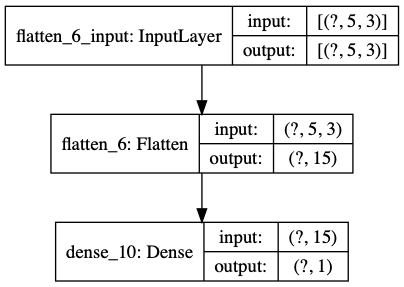

In [276]:
nyse_ann_lin_autoreg = keras.models.Sequential([
    keras.layers.Flatten(input_shape = (5,3,)), 
    keras.layers.Dense(units = 1)
])

print(nyse_ann_lin_autoreg.summary())

keras.utils.plot_model(nyse_ann_lin_autoreg, show_shapes = True, show_layer_names = True)

In [277]:
nyse_ann_lin_autoreg.compile(optimizer = 'rmsprop', loss = 'mse')

nyse_ann_lin_autoreg_history = nyse_ann_lin_autoreg.fit(
    features_train_rnn, target_train, 
    batch_size = 64, epochs = 200, 
    validation_data = (features_test_rnn, target_test)
)

Train on 4276 samples, validate on 1765 samples
Epoch 1/200
4276/4276 [==============================] - 0s 98us/sample - loss: 1.4635 - val_loss: 1.7128
Epoch 2/200
4276/4276 [==============================] - 0s 48us/sample - loss: 1.1518 - val_loss: 1.4449
Epoch 3/200
4276/4276 [==============================] - 0s 56us/sample - loss: 0.9455 - val_loss: 1.2356
Epoch 4/200
4276/4276 [==============================] - 0s 52us/sample - loss: 0.8025 - val_loss: 1.0770
Epoch 5/200
4276/4276 [==============================] - 0s 68us/sample - loss: 0.6946 - val_loss: 0.9506
Epoch 6/200
4276/4276 [==============================] - 0s 40us/sample - loss: 0.6092 - val_loss: 0.8546
Epoch 7/200
4276/4276 [==============================] - 0s 41us/sample - loss: 0.5503 - val_loss: 0.7849
Epoch 8/200
4276/4276 [==============================] - 0s 35us/sample - loss: 0.5076 - val_loss: 0.7336
Epoch 9/200
4276/4276 [==============================] - 0s 41us/sample - loss: 0.4791 - val_loss: 0.694

In [278]:
nyse_ann_lin_autoreg_pred = nyse_ann_lin_autoreg.predict(features_test_rnn)

nyse_ann_lin_autoreg_r2_score = r2_score(
    y_true = target_test, 
    y_pred = nyse_ann_lin_autoreg_pred
)

print(f"ANN-based Linear Autoregression has R2 score: {np.round(nyse_ann_lin_autoreg_r2_score, 3)}")

ANN-based Linear Autoregression has R2 score: 0.415


This model has almost exactly the same $R^2$ score as the one implemented with a `LinearRegression` object, which is what we'd expect: we have simply implemented the same model with a different API.

The major advantage of this approach is that we can use a lot of the neural network-specific regularization strategies (dropout, batch normalization) that wouldn't be available with a conventional `LinearRegression` object. 

The neural network implementation also uses gradient descent to optimize its parameters. When analytical solutions for autoregression models are not available (e.g. when $p$ >> $n$), numerical approaches such as gradient descent can be useful. However, gradient-descent based optimization isn't specific to `keras`: even `sklearn` allows for gradient-descent based optimsation.


The disadvantage of the neural network approach is that it is less readily interpretable than a simple `LinearRegression`-based implementation. It is less straightforward to get the coefficients for each component and asses $p$-values through a neural network-based approach.

## Exercise 11 - Non-Linear AR Model with ANN

**Repeat the previous exercise, but now fit a non-linear AR model by "flattening" the short sequences produced for the RNN model.**

The simplest way to convert a linear ANN-based AR model to a non-linear ANN-based AR model is to use a `ReLU` or non-linear activation for the hidden layer.

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_7 (Flatten)          (None, 15)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 16        
Total params: 16
Trainable params: 16
Non-trainable params: 0
_________________________________________________________________
None


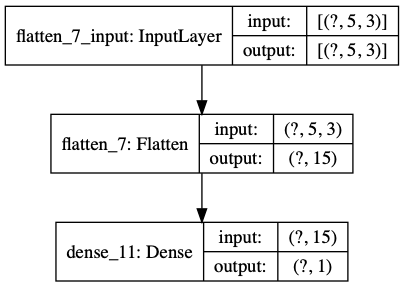

In [279]:
nyse_ann_nonlin_autoreg = keras.models.Sequential([
    keras.layers.Flatten(input_shape = (5,3,)), 
    keras.layers.Dense(units = 1, activation = 'relu')
])


print(nyse_ann_nonlin_autoreg.summary())

keras.utils.plot_model(nyse_ann_nonlin_autoreg, show_shapes = True, show_layer_names = True)

In [280]:
nyse_ann_nonlin_autoreg.compile(optimizer = 'rmsprop', loss = 'mse')

nyse_ann_nonlin_autoreg_history = nyse_ann_nonlin_autoreg.fit(
    features_train_rnn, target_train, 
    batch_size = 64, epochs = 200, 
    validation_data = (features_test_rnn, target_test)
)

Train on 4276 samples, validate on 1765 samples
Epoch 1/200
4276/4276 [==============================] - 0s 100us/sample - loss: 1.7792 - val_loss: 2.1616
Epoch 2/200
4276/4276 [==============================] - 0s 40us/sample - loss: 1.4236 - val_loss: 1.7433
Epoch 3/200
4276/4276 [==============================] - 0s 31us/sample - loss: 1.2105 - val_loss: 1.4737
Epoch 4/200
4276/4276 [==============================] - 0s 37us/sample - loss: 1.0831 - val_loss: 1.3157
Epoch 5/200
4276/4276 [==============================] - 0s 38us/sample - loss: 1.0022 - val_loss: 1.2113
Epoch 6/200
4276/4276 [==============================] - 0s 43us/sample - loss: 0.9431 - val_loss: 1.1339
Epoch 7/200
4276/4276 [==============================] - 0s 36us/sample - loss: 0.8995 - val_loss: 1.0769
Epoch 8/200
4276/4276 [==============================] - 0s 38us/sample - loss: 0.8668 - val_loss: 1.0318
Epoch 9/200
4276/4276 [==============================] - 0s 44us/sample - loss: 0.8399 - val_loss: 0.99

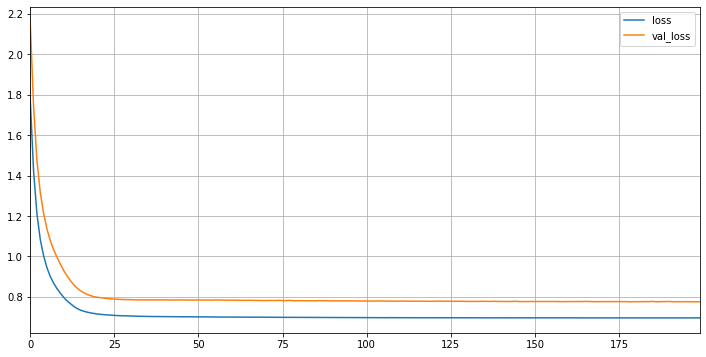

In [281]:
pd.DataFrame(nyse_ann_nonlin_autoreg_history.history).plot(figsize = (12, 6), grid = True)

In [282]:
nyse_ann_nonlin_autoreg_pred = nyse_ann_nonlin_autoreg.predict(features_test_rnn)
nyse_ann_nonlin_autoreg_r2_score = r2_score(
    y_true = target_test, 
    y_pred = nyse_ann_nonlin_autoreg_pred
)

print(f"Test Set R2 Score with ANN-based Non-Linear Regression: {np.round(nyse_ann_nonlin_autoreg_r2_score,2)}")

Test Set R2 Score with ANN-based Non-Linear Regression: 0.28


It looks like this specific implementation of the non-linear autoregression model is 0.28.

What this model is doing is computing a linear combination of all input features and passing it to a **single** non-linear transformer. Its goal is to find the weights $\beta_j$ such that $ReLU(W.X)$ minimises the training loss.

The output is $W.X$ when the weighted sum of the inputs is $\geq 0$, and zero otherwise. 

This specific formulation of the non-linear model is not the same as the model we implemented in the lab, where we were implicitly creating lots of interaction terms between the predictors and using more non-linear transformations.

This is why the non-linear autoregressor with a `weekday` feature from the lab had a test set $R^2$ score of 0.47.

## Exercise 12 - RNN with `day_of_week`

**Consider the RNN fit to the `NYSE` data in Section 10.9.6. Modify the code to allow inclusion of the varable `day_of_week` ad fit the RNN. Compute the test $R^2$.**

The only modification which needs to be made to the training and test data is to merge it with the one-hot encoded version of the `day_of_week` features.

While this sounds trivial, data manipulation for this is a bit involved. 

The idea is that we reshape our `DataFrame` so that it is of dimensions `(date_index, time_lag, feature)`, and then create a `day_of_week` variable for each of these rows using the index.

In [493]:
nyse_cat_data = pd.get_dummies(nyse_data_raw['day_of_week'])
nyse_cat_data

,fri,mon,thur,tues,wed
date,,,,,
1962-12-03,0,1,0,0,0
1962-12-04,0,0,0,1,0
1962-12-05,0,0,0,0,1
1962-12-06,0,0,1,0,0
1962-12-07,1,0,0,0,0
...,...,...,...,...,...
1986-12-24,0,0,0,0,1
1986-12-26,1,0,0,0,0
1986-12-29,0,1,0,0,0


In [284]:
features_train = pd.merge(features_train, nyse_cat_data, left_index = True, right_index = True, how = 'left') 

features_test = pd.merge(features_test, nyse_cat_data, left_index = True, right_index = True, how = 'left') 

In [285]:
print(features_train.shape)
features_train.head() 

(4276, 20)


,DJ_return_L1,log_volume_L1,log_volatility_L1,DJ_return_L2,log_volume_L2,log_volatility_L2,DJ_return_L3,log_volume_L3,log_volatility_L3,DJ_return_L4,log_volume_L4,log_volatility_L4,DJ_return_L5,log_volume_L5,log_volatility_L5,fri,mon,thur,tues,wed
date,,,,,,,,,,,,,,,,,,,,
1962-12-10,0.063012,0.246376,-2.222770,-0.435857,0.965159,-2.093064,0.468721,2.328160,-2.140962,0.959601,1.552041,-2.245414,-0.559615,0.193763,-3.982432,0,1,0,0,0
1962-12-11,-1.347379,0.632207,-1.137747,0.063070,0.246094,-2.221546,-0.435893,0.963910,-2.091756,0.468410,2.327421,-2.139429,0.959704,1.552668,-2.240505,0,0,0,1,0
1962-12-12,0.008042,0.005001,-1.271245,-1.347295,0.631884,-1.136981,0.063025,0.245275,-2.220176,-0.436109,0.963181,-2.090249,0.468531,2.328698,-2.134713,0,0,0,0,1
1962-12-13,0.408428,0.061906,-1.315075,0.008101,0.004745,-1.270422,-1.347317,0.630834,-1.136122,0.062757,0.244553,-2.218601,-0.435955,0.963315,-2.085623,0,0,1,0,0
1962-12-14,-0.415372,-0.406175,-1.359141,0.408480,0.061644,-1.314235,0.008057,0.004071,-1.269500,-1.347437,0.630108,-1.135133,0.062892,0.244084,-2.213740,1,0,0,0,0


In [286]:
print(features_test.shape)
features_test.head()

(1765, 20)


,DJ_return_L1,log_volume_L1,log_volatility_L1,DJ_return_L2,log_volume_L2,log_volatility_L2,DJ_return_L3,log_volume_L3,log_volatility_L3,DJ_return_L4,log_volume_L4,log_volatility_L4,DJ_return_L5,log_volume_L5,log_volatility_L5,fri,mon,thur,tues,wed
date,,,,,,,,,,,,,,,,,,,,
1980-01-09,2.891468,1.728963,0.947014,0.463820,0.946775,0.044711,1.273428,0.391803,0.139855,-0.648777,1.488956,-0.018597,-2.116565,0.562167,0.039155,0,0,0,0,1
1980-01-10,-0.243035,2.578413,0.818593,2.891475,1.728523,0.946899,0.463769,0.945536,0.045015,1.273033,0.391079,0.140153,-0.648615,1.489530,-0.017752,0,0,1,0,0
1980-01-11,1.277790,1.886035,0.845474,-0.242972,2.577882,0.818532,2.891384,1.726814,0.946778,0.463459,0.944808,0.045365,1.273124,0.390734,0.140708,1,0,0,0,0
1980-01-14,-0.069336,1.616795,0.712252,1.277825,1.885578,0.845402,-0.243011,2.575664,0.818472,2.890819,1.726080,0.946640,0.463580,0.944926,0.046093,0,1,0,0,0
1980-01-15,0.717323,1.604764,0.636465,-0.069276,1.616367,0.712236,1.277761,1.883776,0.845329,-0.243247,2.574922,0.818404,2.890851,1.726853,0.945723,0,0,0,1,0


In [454]:
def reshape_with_date(row):
    row_date = row.index.values[0]
    row_reshaped = row.values.reshape(5, 3)
    row_df = pd.DataFrame(row_reshaped)
    row_df['date'] = row_date
    row_df.set_index('date', inplace = True)
    row_df = pd.merge(row_df, nyse_cat_data, how = 'left', 
                     left_index = True, right_index = True)
    return row_df.values

In [455]:
# Extract the number of examples in the train and test set
n_train = features_train.shape[0]
n_test = features_test.shape[0]

In [465]:
row_df.shape

(5, 8)

In [473]:
# Ideally, this should be implemented with `apply`
# But I keep getting an error in the pd.merge phase 
# Where one of the the datetimes in row_df and nyse_features_cat 
# is treated as string and the other as datetimen64
# So I'll try with for loop

In [ ]:
nyse_cat_data.reset_index(inplace = True)

In [498]:
features_train_rnn_new = np.empty(shape = (n_train, 5, 8))
features_test_rnn_new = np.empty(shape = (n_test, 5, 8))

In [ ]:
for row_ix in tqdm.tqdm(np.arange(n_train)):
    row = features_train.iloc[[row_ix]]
    row_date = row.index.values[0]
    row_reshaped = row.values.reshape(5, 3)
    row_df = pd.DataFrame(row_reshaped)
    row_df['date'] = pd.to_datetime(row_date)
    
    # row_df.set_index('date', inplace = True)
    row_df = pd.merge(row_df, nyse_cat_data, how = 'left', on = 'date', left_index = False, right_index = False)
    
    row_df.drop(['date'], axis = 1, inplace = True)
    features_train_rnn_new[row_ix] = row_df.values

In [506]:
for row_ix in tqdm.tqdm(np.arange(n_test)):
    row = features_test.iloc[[row_ix]]
    row_date = row.index.values[0]
    row_reshaped = row.values.reshape(5, 3)
    row_df = pd.DataFrame(row_reshaped)
    row_df['date'] = pd.to_datetime(row_date)
    
    # row_df.set_index('date', inplace = True)
    row_df = pd.merge(row_df, nyse_cat_data, how = 'left', on = 'date', left_index = False, right_index = False)
    
    row_df.drop(['date'], axis = 1, inplace = True)
    features_test_rnn_new[row_ix] = row_df.values

100%|██████████| 1765/1765 [00:11<00:00, 149.26it/s]


In [507]:
# Check shapes 
print("features_train_rnn_new shape: ", features_train_rnn_new.shape)
print("features_test_rnn_new shape: ", features_test_rnn_new.shape)

features_train_rnn_new shape:  (4276, 5, 8)
features_test_rnn_new shape:  (1765, 5, 8)


We use the same RNN architecture as the lab.

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 12)                252       
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 13        
Total params: 265
Trainable params: 265
Non-trainable params: 0
_________________________________________________________________
None


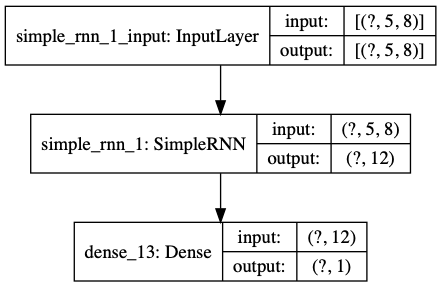

In [509]:
nyse_rnn = keras.models.Sequential([
    keras.layers.SimpleRNN(units = 12, input_shape = (5, 8),
    dropout = 0.1, recurrent_dropout = 0.1), 
    keras.layers.Dense(units = 1)
])

print(nyse_rnn.summary());

keras.utils.plot_model(nyse_rnn, show_shapes = True, show_layer_names = True)

In [511]:
nyse_rnn.compile(optimizer = 'RMSprop', loss = 'mse')
nyse_rnn_history = nyse_rnn.fit(
    x = features_train_rnn_new, 
    y = target_train, 
    batch_size = 64, 
    epochs = 200, 
    validation_data = (features_test_rnn_new, target_test)
)

Train on 4276 samples, validate on 1765 samples
Epoch 1/200
4276/4276 [==============================] - 1s 339us/sample - loss: 0.9285 - val_loss: 0.9387
Epoch 2/200
4276/4276 [==============================] - 0s 78us/sample - loss: 0.7348 - val_loss: 0.8367
Epoch 3/200
4276/4276 [==============================] - 0s 77us/sample - loss: 0.6674 - val_loss: 0.7899
Epoch 4/200
4276/4276 [==============================] - 0s 76us/sample - loss: 0.6331 - val_loss: 0.7603
Epoch 5/200
4276/4276 [==============================] - 0s 76us/sample - loss: 0.6095 - val_loss: 0.7441
Epoch 6/200
4276/4276 [==============================] - 0s 76us/sample - loss: 0.6036 - val_loss: 0.7285
Epoch 7/200
4276/4276 [==============================] - 0s 75us/sample - loss: 0.6053 - val_loss: 0.7245
Epoch 8/200
4276/4276 [==============================] - 0s 87us/sample - loss: 0.5826 - val_loss: 0.7169
Epoch 9/200
4276/4276 [==============================] - 0s 78us/sample - loss: 0.5779 - val_loss: 0.71

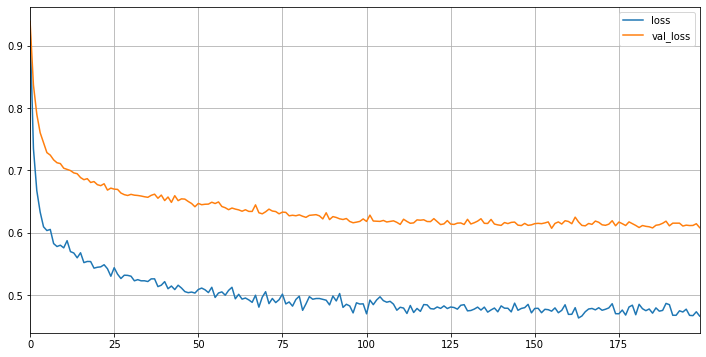

In [512]:
pd.DataFrame(nyse_rnn.history.history).plot(figsize = (12, 6), grid = True)

In [513]:
nyse_rnn_pred = nyse_rnn.predict(features_test_rnn_new)
nyse_rnn_r2_score = r2_score(y_true = target_test, y_pred = nyse_rnn_pred)

print(f"Test R2 with RNN that has day_of_week: {np.round(nyse_rnn_r2_score, 4)}")

Test R2 with RNN that has day_of_week: 0.4365


This still is much better than the original RNN and the linear autoregressor without `day_of_week` but is not as good as the simple non-linear ANN we trained earlier. 

## Exercise 13: `IMDB` Vocabulary Grid Search

**Repeat the analysis of Lab 10.9.5 on the `IMDb` data using a similarly structured neural network. There we used a dictionary of size 10,000. Consider the effets of varying the dictionary size. Try the values 1000, 3000, 5000, and 10,0000, and compare the results.**

We're essentially performing a grid search i.e. a search over the hyperparameter space of our dictionary size. 

To simplify this process, I will wrap all the code used in the lab to train the IMDb model into a single function `train_imdb` model which will perform all the necessary preprocessing and output the test set accuracy.

The only inputs to this function are `n_words` so that I can load `imdb` data with a different vocabulary length, and a `verbose` flag that will let me choose when to output ANN training logs.

In [544]:
def train_imdb_model(n_words, verbose = 0):
    (X_train, y_train), (X_test, y_test) = imdb.load_data(num_words = n_words)

    # What is the shape of the original data?
    print(dt.datetime.now(), "\t Checking original data shapes\n")
    print("X_train: ", X_train.shape)
    print("X_test: ", X_test.shape)
    print("y_train: ", y_train.shape)
    print("y_test: ", y_test.shape)
    
    # Initialize empty arrays with one row per sample and one column per word 
    # Separately for training and test data
    print(dt.datetime.now(), "\t One-hot encoding of train and test\n")
    X_train_1h = np.zeros(shape = (X_train.shape[0], n_words))
    X_test_1h = np.zeros(shape = (X_test.shape[0], n_words))
    
    # Iterate over each row in training set, find the corresponding unique words, 
    # set their indexes in X_train_1h to 1.0 
    for i in range(X_train.shape[0]):
        X_train_1h[i, np.unique(X_train[i])] = 1.0
        
    # Do the same on the test data
    for i in range(X_test.shape[0]):
        X_test_1h[i, np.unique(X_test[i])] = 1.0
        
    # Check dimensions of train and test matrices 
    print(dt.datetime.now(), "\tChecking shapes after 1H encoding\n")
    print("X_train: ", X_train.shape)
    print("X_train_1h: ", X_train_1h.shape)
    print("X_test: ", X_test.shape)
    print("X_test_1h: ", X_test_1h.shape)

    # Y-dimensions should be unchanged 
    print("y_train: ", y_train.shape)
    print("y_test: ", y_test.shape)
    
    print(dt.datetime.now(), "\tTrain-Val Split\n")
    X_train_1h, X_val_1h, y_train, y_val = train_test_split(X_train_1h, y_train, test_size = 2000)

    [print(f"{name}: {arr.shape}") for (name, arr) in {
    'X_train_1h': X_train_1h, 
    'X_val_1h': X_val_1h, 
    'y_train': y_train, 
    'y_val': y_val
    }.items()];
    
    print(dt.datetime.now(), "\tInstantiating model\n")
    imdb_ann = keras.models.Sequential([
        keras.layers.Input(shape = (X_train_1h.shape[1]), ), 
        keras.layers.Dense(units = 16, activation = 'relu'), 
        keras.layers.Dense(units = 1, activation = 'sigmoid')
    ])
    
    imdb_ann.compile(optimizer = 'rmsprop', 
                     loss = 'binary_crossentropy', 
                     metrics = ['accuracy'])
    
    print(dt.datetime.now(), "\tFittng model")
    imdb_ann_history = imdb_ann.fit(
    x = X_train_1h, y = y_train, batch_size = 512, epochs = 20,
    validation_data = (X_val_1h, y_val), verbose = verbose)
          
    pd.DataFrame(imdb_ann_history.history).plot(figsize = (12, 6),
                                               grid = True)
    
    print(dt.datetime.now(), "\tEvaluating on test set")
    imdb_ann_pred = imdb_ann.predict_classes(X_test_1h)
    imdb_ann_accuracy = accuracy_score(y_true = y_test, y_pred = imdb_ann_pred)
    print(f"ANN Test Set Accuracy with {n_words} words is : {np.round(imdb_ann_accuracy, 2)}")
    print("*" * 100)

### 1000 Words

2022-04-17 22:16:19.345487 	 Checking original data shapes

X_train:  (25000,)
X_test:  (25000,)
y_train:  (25000,)
y_test:  (25000,)
2022-04-17 22:16:19.345817 	 One-hot encoding of train and test

2022-04-17 22:16:21.593349 	Checking shapes after 1H encoding

X_train:  (25000,)
X_train_1h:  (25000, 1000)
X_test:  (25000,)
X_test_1h:  (25000, 1000)
y_train:  (25000,)
y_test:  (25000,)
2022-04-17 22:16:21.593662 	Train-Val Split

X_train_1h: (23000, 1000)
X_val_1h: (2000, 1000)
y_train: (23000,)
y_val: (2000,)
2022-04-17 22:16:21.930929 	Instantiating model

2022-04-17 22:16:21.974812 	Fittng model
2022-04-17 22:16:26.940342 	Evaluating on test set
ANN Test Set Accuracy with 1000 words is : 0.86
****************************************************************************************************


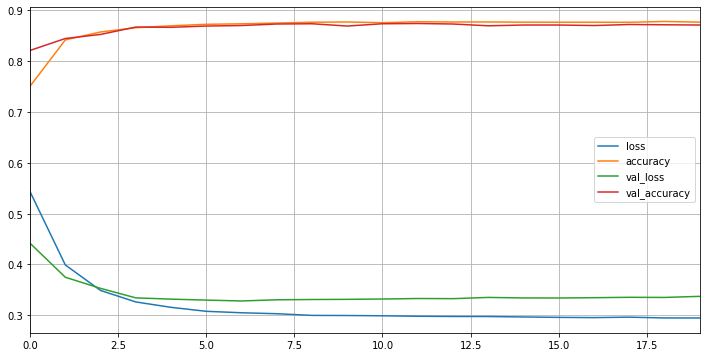

In [538]:
train_imdb_model(n_words = 1000)

### 3000 Words

2022-04-17 22:16:38.560724 	 Checking original data shapes

X_train:  (25000,)
X_test:  (25000,)
y_train:  (25000,)
y_test:  (25000,)
2022-04-17 22:16:38.561857 	 One-hot encoding of train and test

2022-04-17 22:16:41.522685 	Checking shapes after 1H encoding

X_train:  (25000,)
X_train_1h:  (25000, 3000)
X_test:  (25000,)
X_test_1h:  (25000, 3000)
y_train:  (25000,)
y_test:  (25000,)
2022-04-17 22:16:41.523969 	Train-Val Split

X_train_1h: (23000, 3000)
X_val_1h: (2000, 3000)
y_train: (23000,)
y_val: (2000,)
2022-04-17 22:16:42.630465 	Instantiating model

2022-04-17 22:16:42.697115 	Fittng model
2022-04-17 22:16:52.466796 	Evaluating on test set
ANN Test Set Accuracy with 3000 words is : 0.87
****************************************************************************************************


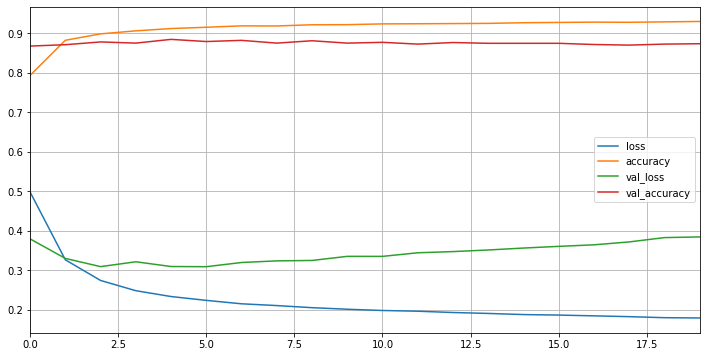

In [539]:
train_imdb_model(n_words = 3000)

### 5000 Words

2022-04-17 22:16:59.654716 	 Checking original data shapes

X_train:  (25000,)
X_test:  (25000,)
y_train:  (25000,)
y_test:  (25000,)
2022-04-17 22:16:59.655282 	 One-hot encoding of train and test

2022-04-17 22:17:03.105758 	Checking shapes after 1H encoding

X_train:  (25000,)
X_train_1h:  (25000, 5000)
X_test:  (25000,)
X_test_1h:  (25000, 5000)
y_train:  (25000,)
y_test:  (25000,)
2022-04-17 22:17:03.106137 	Train-Val Split

X_train_1h: (23000, 5000)
X_val_1h: (2000, 5000)
y_train: (23000,)
y_val: (2000,)
2022-04-17 22:17:04.992738 	Instantiating model

2022-04-17 22:17:05.123429 	Fittng model
2022-04-17 22:17:18.552430 	Evaluating on test set
ANN Test Set Accuracy with 5000 words is : 0.86
****************************************************************************************************


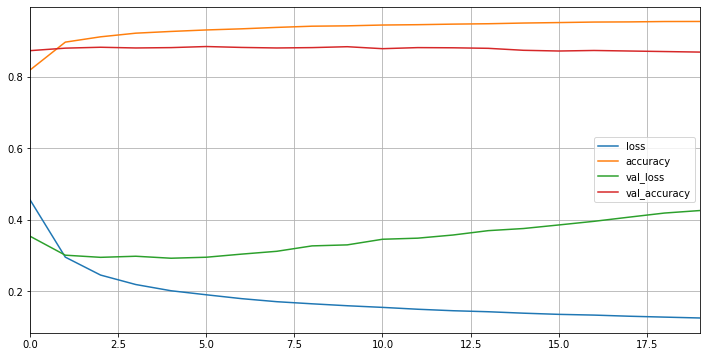

In [540]:
train_imdb_model(n_words = 5000)

### 10,000 Words

2022-04-17 22:17:28.908774 	 Checking original data shapes

X_train:  (25000,)
X_test:  (25000,)
y_train:  (25000,)
y_test:  (25000,)
2022-04-17 22:17:28.909061 	 One-hot encoding of train and test

2022-04-17 22:17:32.578460 	Checking shapes after 1H encoding

X_train:  (25000,)
X_train_1h:  (25000, 10000)
X_test:  (25000,)
X_test_1h:  (25000, 10000)
y_train:  (25000,)
y_test:  (25000,)
2022-04-17 22:17:32.578934 	Train-Val Split

X_train_1h: (23000, 10000)
X_val_1h: (2000, 10000)
y_train: (23000,)
y_val: (2000,)
2022-04-17 22:17:35.158803 	Instantiating model

2022-04-17 22:17:35.222712 	Fittng model
2022-04-17 22:17:57.229898 	Evaluating on test set
ANN Test Set Accuracy with 10000 words is : 0.86
****************************************************************************************************


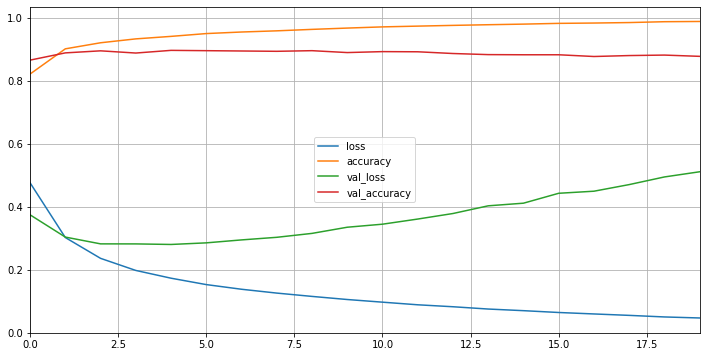

In [541]:
train_imdb_model(n_words = 10000)

### 50,000 Words

2022-04-17 22:23:14.961122 	 Checking original data shapes

X_train:  (25000,)
X_test:  (25000,)
y_train:  (25000,)
y_test:  (25000,)
2022-04-17 22:23:14.961391 	 One-hot encoding of train and test

2022-04-17 22:23:19.495267 	Checking shapes after 1H encoding

X_train:  (25000,)
X_train_1h:  (25000, 50000)
X_test:  (25000,)
X_test_1h:  (25000, 50000)
y_train:  (25000,)
y_test:  (25000,)
2022-04-17 22:23:19.495910 	Train-Val Split

X_train_1h: (23000, 50000)
X_val_1h: (2000, 50000)
y_train: (23000,)
y_val: (2000,)
2022-04-17 22:23:36.317383 	Instantiating model

2022-04-17 22:23:36.427638 	Fittng model
Train on 23000 samples, validate on 2000 samples
Epoch 1/20
23000/23000 [==============================] - 16s 712us/sample - loss: 0.4503 - accuracy: 0.8278 - val_loss: 0.3356 - val_accuracy: 0.8865
Epoch 2/20
23000/23000 [==============================] - 16s 705us/sample - loss: 0.2507 - accuracy: 0.9232 - val_loss: 0.2817 - val_accuracy: 0.8975
Epoch 3/20
23000/23000 [===============

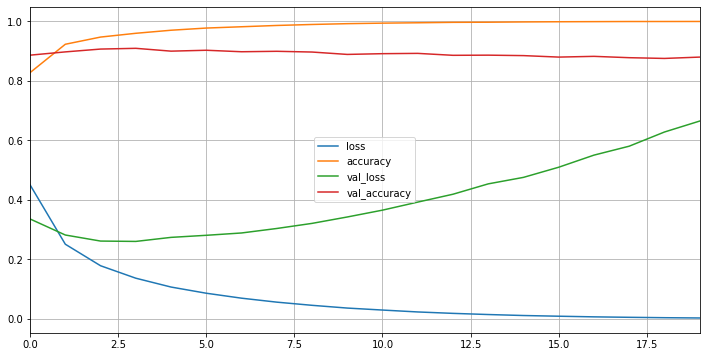

In [545]:
train_imdb_model(n_words = 50000, verbose = 1)

I don't observe any drastic changes in accuracy with a change in vocabulary size. It seems regardless of the size of the vocabulary, the test set accuracy is about the same ~0.86. With 5000 words, we observe a test set accuracy of 0.87. 

Intuitively, I expected an increase in test set accuracy with increasing number of words. The idea is that the more words we're using in encoding our features, the more features we have to work with and the lower the probabiliity that we lose out on important contextual information by excludng some words.

However, the downside is that our feature space's dimensionalitiy increase substantially. This may lead to a curse of dimensionality where we require increasingly more data to ensure we don't overfit. 

Generally, though, it seems that the choice of sequence length has a greater impact on the test set accuracy than choice of vocabulary size, as despite wildly different vocabulary sizes, the model seems to be performing roughly the same.

The general trend I did observe was that the low performance is generally because of overfitting. Maybe these models should be trained with fewer epochs.